Si tienen conda instalado, hay que correr:

conda env create --name widgets --file wid-env.txt

si todo sale bien, correr:

`conda activate widgets`

`python -m ipykernel install --user --name widgets --display-name "widg"`

Si todo sale bien, pueden correr:

`jupyter-lab`

En el menú `Kernel` seleccionar `Change Kernel` y elegir `widg` si no está seleccionado por defecto

In [1]:
import ipywidgets as widgets
from ipywidgets.widgets import HBox,VBox
import matplotlib.pyplot as plt
import matplotlib as mpl
from ipywidgets import interactive, interactive_output
import numpy as np
from scipy.optimize import curve_fit

# Widgets

## Testtesttest

In [ ]:
widgets.IntSlider()

In [ ]:
a = widgets.FloatText()
b = widgets.FloatSlider()
display(a,b)

mylink = widgets.jslink((a, 'value'), (b, 'value'))

In [ ]:
c=widgets.FloatRangeSlider(
    value=[5, 7.5],
    min=0,
    max=10.0,
    step=0.1,
    description='Test:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.3f',
)
display(c)

## Funciones

In [2]:
#Es mecesario correr esta celda
def mask_line(x,y,a,b):
    x_ma=np.ma.masked_outside(x,a,b)
    mask = np.ma.getmask(x_ma)
    f_ma=np.ma.array(y,mask=mask)    
    return x_ma,f_ma
def gaussian(x,cont,inten,m,sigma):
    return cont - inten*np.exp(-((x-m)/sigma)**2)
def gaussians(x,cont,inten1,m1,sigma1,inten2,m2,sigma2):
    return cont - inten1*np.exp(-((x-m1)/sigma1)**2) - inten2*np.exp(-((x-m2)/sigma2)**2)

### No implementado

In [ ]:
c=1
m=130
sigma=0.2
inten=0.2
def gaussian(x,cont=1,inten=0.1,m=130,sigma=0.05):
    return cont - inten*np.exp(-((x-m)/sigma)**2)
xx = np.linspace(128, 132, num=2000)

xx = np.linspace(128, 132, num=2000)
faux=gaussian(xx)+np.random.normal(0.01,0.005,2000)
def p(a,b):
#    fig,ax=plt.subplots()
    ax.set_ylim(0.85, 1.03)
    ax.set_xlim(xx[0],xx[-1])
    v,w=mask_line(xx,faux,a,b)
    ax.plot(xx,faux,c='r',linewidth=0.5,label='line')
    ax.plot(v,w,c='g',linewidth=0.55,label='selected range')

def e(a,b,sigma,c,inten,m):
    global p0,v,w
#    fig,ax=plt.subplots()
    ax.set_ylim(0.75, 1.03)
    ax.set_xlim(xx[0],xx[-1])
    v,w=mask_line(xx,faux,a,b)

    ax.plot(xx, gaussian(xx,c,inten,m,sigma),c='b',linewidth=0.5,label='p0 selection')
    ax.plot(xx,faux,c='grey',linewidth=0.5,label='line')
    ax.plot(v,w,c='g',linewidth=0.5,label='selected for fit')
    if fitted is True:
        cont_f,intn_f,m_f,sigma_f=p1
        ax.plot(x,gaussian(x,cont_f,intn_f,m_f,sigma_f),c='r',label='fitted line')
    p0=[c,inten,m,sigma]
    plt.show()

## Plot interactivo

### Una gaussiana

Generamos un vector entre 128 y 132 de 2000 puntos

creo una linea falsa, la funcion `gaussian genera` un continuo menos una gaussiana (una linea artificial)

np.random.normal genera un vector de 2000 con valores de ruido gaussiano, centrado en 0.01 y dispersion 0.005

al sumarlos parece una linea falsa.

`np.ma.masked_outside` nos deja elegir un rango que vamos a elegir más adelante

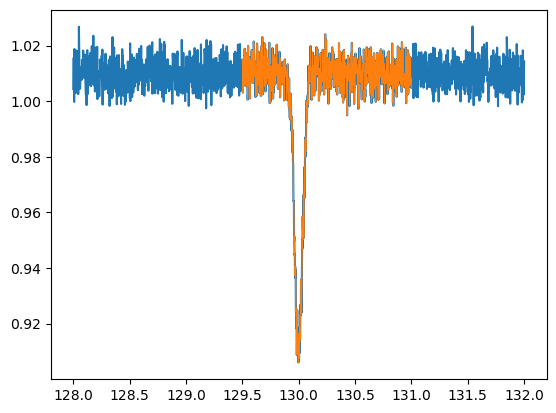

In [19]:
xx = np.linspace(128, 132, num=2000)
faux=gaussian(xx,cont=1,inten=0.1,m=130,sigma=0.05)+np.random.normal(0.01,0.005,2000)
masked=np.ma.masked_outside(xx,129.5,131)
mask = np.ma.getmask(masked)
fauma=np.ma.array(faux,mask=mask)

plt.plot(xx,faux)
plt.plot(masked,fauma,linewidth=0.8)

Ahora pasa todo junto, el plot es interactivo y va a generar muchos sliders que aun no estan bien nombrados:
- `a` es el extremo izquiero de seleccion
- `b` el extremos derecho de la seleccion
la selección es donde se hará el ajuste y se va a ver en verde
- `v` `w` son los vectores de long de onda y flux, cortados en el rango [a,b]
- `c` es el continuo
- `inten` es la intensidad central de la linea
- `m` es el centro ó, para nuestro uso, la longitud de onda central
- `sigma` es la dispesion de la gaussiana o para nuestro uso FWHM
Hasta aquí son parametros de entrada para el fit
- [ ] `fit` calcula el fit y plotea (siempre que esta activado y se muevan los parametros de arriba, calculara un nuevo fit y lo graficará)
pueden dejar marcado `fit` y ver cómo variar los parametros de entrada cambia el ajuste, por lo que noté yo el unico que afecta es la m

los parámetros de entrada se van a guardar en la variable `p0`, y los de salida se guardan en `p1` y despues son usados para generar el plot rojo del ajuste

In [ ]:
#Better widgets
fit_range = widgets.FloatRangeSlider(
    value=[129, 130],
    min=xx[1],
    max=xx[-2],
    step=0.1,
    description='Test:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.3f',
    layout={'width':'400px'}
)
fit_button = widgets.ToggleButton(value=False,
    description='Fit',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='fit gaussians',
    icon='check')

In [ ]:
xx = np.linspace(128, 132, num=2000)
faux=gaussian(xx,cont=1,inten=0.1,m=130,sigma=0.05)+np.random.normal(0.01,0.005,2000)
masked=np.ma.masked_outside(xx,129.5,130.5)
mask = np.ma.getmask(masked)
fauma=np.ma.array(faux,mask=mask)
def e(ab,sigma,c,inten,m,fit):
    global p0,v,w,fig,ax
    fig,ax=plt.subplots()
    ax.set_ylim(0.85, 1.03)
    ax.set_xlim(xx[0],xx[-1])
    v,w=mask_line(xx,faux,ab[0],ab[1])
    p0=[c,inten,m,sigma]
    ax.plot(xx, gaussian(xx,c,inten,m,sigma),c='b',linewidth=0.5,label='p0 selection')
    ax.plot(xx,faux,c='grey',linewidth=0.5,label='line')
    ax.plot(v,w,c='g',linewidth=0.5,label='selected for fit')
    if fit is True:
        global p1
        cont_f,intn_f,m_f,sigma_f=curve_fit(gaussian, v, w,p0)[0]
        ax.plot(v,gaussian(v,cont_f,intn_f,m_f,sigma_f),c='r',label='fitted line')
    plt.show()

interactive_plot = interactive(e,ab=fit_range,inten=(0.01,1,0.05), m=(125, 135,0.5), sigma=(0.05, 0.4, 0.01),c=(0.7,1.2,0.01),fit=fit_button)
#la linea de arriba dice el rango y el paso en que variaran los sliders, por ej `a` ira desde el principio del array longitud de onda, hasta la mitad, con un paso de 0.01

output = interactive_plot.children[-1]
for i in range(5):
    interactive_plot.children[i].layout.width='400px'
output.layout.height = '500px'
interactive_plot #descomentar para probar 1 gaussiana


## 2 gaussianas

In [3]:
def gaussian(x,cont=1,inten=0.1,m=130,sigma=0.05):
    return cont - inten*np.exp(-((x-m)/sigma)**2)
def gaussians(x,cont,inten1,m1,sigma1,inten2,m2,sigma2):
    return cont - inten1*np.exp(-((x-m1)/sigma1)**2) - inten2*np.exp(-((x-m2)/sigma2)**2)

Ahora pasa todo junto, el plot es interactivo y va a generar muchos sliders que aun no estan bien nombrados:
- `a` es el extremo izquiero de seleccion 
- `b` el extremos derecho de la seleccion
la selección es donde se hará el ajuste y se va a ver en verde
- `x` `y` son los vectores de long de onda y flux, cortados en el rango [a,b]
- `c` es el continuo
- `inten1,2` es la intensidad central de la linea 1 o 2
- `m1,2` es el centro ó, para nuestro uso, la longitud de onda central 1 o 2
- `sigma1,2` es la dispesion de la gaussiana o para nuestro uso FWHM 1 o 2
Hasta aquí son parametros de entrada para el fit
- [ ] `fit` calcula el fit y plotea (siempre que esta activado y se muevan los parametros de arriba, calculara un nuevo fit y lo graficará)
pueden dejar marcado `fit` y ver cómo variar los parametros de entrada cambia el ajuste, el unico que afecta es la m, igual que el caso para una sola gaussiana
- los parámetros de entrada se van a guardar en la variable `p02`, y los de salida se guardan en `p2` y despues son usados para generar el plot rojo del ajuste

ATENCION: dejar marcado `fit` recalcula cada vez que movemos un slider y puede trabarse un poquito, fijensé si la compu se lo banca. En unos días lo voy a mejorar pero por ahora sirve para jugar

In [3]:
xx = np.linspace(128, 132, num=2000)
faux=gaussians(xx,1,0.3,130,0.2,0.1,130.5,0.1)+np.random.normal(0.01,0.005,2000)
masked=np.ma.masked_outside(xx,129.5,130.5)
mask = np.ma.getmask(masked)
fauma=np.ma.array(faux,mask=mask)

#Better widgets
fit_range = widgets.FloatRangeSlider(
    value=[129, 130],
    min=xx[1],
    max=xx[-2],
    step=0.1,
    description='Range to fit:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.3f',
    layout={'width':'500px'},
    style = {'description_width': 'initial'}
)
plot_range = widgets.FloatRangeSlider(
    value=[xx[1], xx[-1]],
    min=xx[1],
    max=xx[-1],
    step=0.1,
    description='Range to plot:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.3f',
    layout={'width':'500px'},
    style = {'description_width': 'initial'}
)
sigma1 = widgets.FloatSlider(
    value = 0.05,
    min = 0.01,
    max = 0.3,
    step = 0.01,
    description = 'σ(FWHM) linea 1',
    continuous_update=True,
    readout_format='.3f',
    layout={'width':'500px'},
    style = {'description_width': 'initial'})
bsigma1 = widgets.BoundedFloatText(
    value = 0.05,
    min = 0.01,
    max = 0.3,
    step = 0.01)

sigma2 = widgets.FloatSlider(
    value = 0.05,
    min = 0.005,
    max = 0.3,
    step = 0.01,
    description = 'σ(FWHM) linea 2',
    continuous_update=True,
    readout_format='.3f',
    layout={'width':'500px'},style = {'description_width': 'initial'})
bsigma2 = widgets.BoundedFloatText(
    value = 0.05,
    min = 0.01,
    max = 0.3,
    step = 0.01)

cont = widgets.FloatSlider(
    value = 1.01,
    min = 0.91,
    max = 1.31,
    step = 0.02,
    description = 'Nivel del continuo',
    continuous_update=True,
    readout_format='.3f',
    layout={'width':'500px'},style = {'description_width': 'initial'})
bcont = widgets.BoundedFloatText(
    min = 0.91,
    max = 1.31,
    step = 0.02,)


int1= widgets.FloatSlider(
    value = 0.2,
    min = 0.01,
    max = 0.9,
    step = 0.02,
    description = 'Intensidad de linea 1',
    continuous_update=True,
    readout_format='.3f',
    layout={'width':'500px'},style = {'description_width': 'initial'})
bint1 = widgets.BoundedFloatText(   
    min = 0.01,
    max = 0.9,
    step = 0.02)

int2= widgets.FloatSlider(
    value = 0.15,
    min = 0.01,
    max = 0.9,
    step = 0.02,
    description = 'Intensidad de linea 2',
    continuous_update=True,
    readout_format='.3f',
    layout={'width':'500px'},style = {'description_width': 'initial'})
bint2 = widgets.BoundedFloatText(
    min = 0.01,
    max = 0.9,
    step = 0.02,)

cent1= widgets.FloatSlider(
    value = xx[900],
    min = xx[0],
    max = xx[-1],
    step = 0.02,
    description = 'Centro de linea 1',
    continuous_update=True,
    readout_format='.3f',
    layout={'width':'500px'},style = {'description_width': 'initial'})
bcent1 = widgets.BoundedFloatText(
    min = xx[0],
    max = xx[-1],
    step = 0.02,
)

cent2= widgets.FloatSlider(
    value = xx[1100],
    min = xx[0],
    max = xx[-1],
    step = 0.02,
    description = 'Centro de linea 2',
    continuous_update=True,
    readout_format='.3f',
    layout={'width':'500px'},style = {'description_width': 'initial'})
bcent2 = widgets.BoundedFloatText(
    min = xx[0],
    max = xx[-1],
    step = 0.02)

plot_fit_button = widgets.ToggleButton(value=False,
    description='Plot Fit',
    disabled=True,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='plot gaussians',
    icon='graph',
    continuous_update = False,
    width='auto')

link_button = widgets.Button(value=False,
    description='link',
    disabled=True,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='link fit results with sliders value',
    icon='sliders',
    width='auto')

fit_button = widgets.Button(value=False, description='Fit Parameters',icon='wrench',width='50%')
                            


links = []
#cl = widgets.link((cont,'value','min'),(bcont,'value','min'))
param_wids = [cont,int1,cent1,sigma1,int2,cent2,sigma2]
bparam_wids = [bcont,bint1,bcent1,bsigma1,bint2,bcent2,bsigma2]

for w,b in zip(param_wids,bparam_wids):
    links.append(widgets.link((w,'value'),(b,'value')))

def fit_params(b):
    global p2
    p2=curve_fit(gaussians, x, y,p02)
    plot_fit_button.disabled = False
    
def link_fit(b):
    bparam_wids = [bcont,bint1,bcent1,bsigma1,bint2,bcent2,bsigma2]
    for wid,val in zip(bparam_wids,p2[0]):
        wid.value=val
        


In [4]:
xx = np.linspace(128, 132, num=2000)
faux=gaussians(xx,1,0.3,130,0.2,0.1,130.5,0.1)+np.random.normal(0.01,0.005,2000)
masked=np.ma.masked_outside(xx,129.5,130.5)
mask = np.ma.getmask(masked)
fauma=np.ma.array(faux,mask=mask)

def e(rang,ab,c,inten1,m1,sigma1,inten2,m2,sigma2,plot_fit):
    fig,ax=plt.subplots()

    global p02,x,y#,fig,ax
    c,inten1,m1,sigma1,inten2,m1,sigma1
    ax.set_ylim(0.7, 1.03)
    ax.set_xlim(rang[0],rang[1])
    x,y=mask_line(xx,faux,ab[0],ab[1])
    p02=[c,inten1,m1,sigma1,inten2,m2,sigma2]
    ax.plot(xx, gaussian(xx,c,inten1,m1,sigma1),'--',c='blue',linewidth=1,label='p0 selection for line 1')
    ax.plot(xx, gaussian(xx,c,inten2,m2,sigma2),'--',c='red',linewidth=1,label='p0 selection for line 2')
    ax.plot(xx, gaussians(xx,c,inten1,m1,sigma1,inten2,m2,sigma2),c='k',linewidth=1,label='p0 selection')
    ax.plot(xx,faux,c='grey',linewidth=0.7,alpha=0.5,label='line')
    ax.plot(x,y,c='green',linewidth=0.9,label='selected for fit')
#    plt.legend()

    

    if plot_fit is True:
        cont_f,intn_f1,m_f1,sigma_f1,intn_f2,m_f2,sigma_f2=p2[0]        
        ax.plot(x,gaussians(x,cont_f,intn_f1,m_f1,sigma_f1,intn_f2,m_f2,sigma_f2),c='r',alpha=0.5,label='fitted line')
        link_button.disabled = False

box_layout = widgets.Layout(display='flex',
                    flex_flow='column',
                    align_items='stretch',
                    border='',
                    width='40%')
wids = widgets.VBox([plot_range,fit_range,
                     HBox([cont,bcont]),
                     HBox([int1,bint1]),
                     HBox([cent1,bcent1]),
                     HBox([sigma1,bsigma1]),
                     HBox([int2,bint2]),
                     HBox([cent2,bcent2]),
                     HBox([sigma2,bsigma2]),
                     HBox([fit_button,plot_fit_button,link_button],width='auto')],
                     layout=box_layout)
interactive_plot = interactive_output(e,{'rang':plot_range,'ab':fit_range,'c':cont,
                               'inten1':int1, 'm1':cent1, 'sigma1':sigma1,
                               'inten2':int2, 'm2':cent2, 'sigma2':sigma2,
                               'plot_fit':plot_fit_button})

link_button.on_click(link_fit)
fit_button.on_click(fit_params)
display(widgets.HBox([wids,interactive_plot]))

In [46]:
p2[0][-1]

0.09927736906374898

In [24]:
print(f"cont={p2[0][0]},\n int1={p2[0][1]},µ={p2[0][2]},s={p2[0][3:]}")

cont=1.009965824247898,
 int1=0.3003101222702103,µ=130.00032992968647,s=[1.99650620e-01 1.00367299e-01 1.30500095e+02 1.00729199e-01]


La linea cyan muestra la gaussiana generada para los parametros 1, la magenta para la generada por parametros 2

la negra es una suma de ambas(parecido a los que muestra iraf, solo que pre-fiteo) 

si estan muy separadas, la negra va a tapar las 2 indiduales; 

la roja es el ajuste.

In [ ]:
p2

## Unused

In [ ]:
ranged=widgets.FloatRangeSlider(
    value=[5, 7.5],
    min=0,
    max=10.0,
    step=0.1,
    description='Test:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)


### Botones

In [ ]:
#con parametros estimados de p0 devuelve p1
fit_button = widgets.Button(description='fit gaussian')
#display(fit_button,output)
def fit_on_click(b):
    global p1,fitted

    p1=curve_fit(gaussian, v, w,p0)[0]
    fitted = True

    with output:
        print(f"input params where:{p0}\n and are now {p1}")
        
#fit_button.on_click(fit_on_click)

In [ ]:
#replotea con losp parámetros de p1
replot_button = widgets.Button(description='replot')
#display(replot_button,output)
def on_click_replot(b,p1):
#    fig,ax=plt.subplots()
    cont_f,intn_f,m_f,sigma_f=p1
    ax.plot(xx,gaussian(xx,cont_f,intn_f,m_f,sigma_f),c='r',label='og')
    ax.plot(xx,faux,c='b',linewidth=0.15,label='noisy')
    ax.plot(v,w,c='g',linewidth=0.25,label='selected')
    ax.legend()            
#replot_button.on_click(on_click_replot(replot_button,p1))

In [ ]:
cont_f,intn_f,m_f,sigma_f=fit[0]

In [ ]:
fig,ax=plt.subplots()
ax.plot(x,d(x)+0.05,c='r',linewidth=0.2,label='og')
ax.plot(x,faux,c='b',linewidth=0.2,label='noisy')
ax.plot(masked,fauma,c='g',linewidth=0.2,label='selected')
ax.plot(masked,d(x,cont_f,intn_f,m_f,sigma_f),linewidth=0.4,c='b')
plt.legend()
#el error esta mal sumado y el ajuste va a estar raro